# Analyzing New York City employees' payroll database 

## Data Source: [NYC open data](https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e/data)

In [1]:
import pandas as pd
df = pd.read_csv('Citywide_Payroll_Data__Fiscal_Year_.csv')
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.lower()
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
df.shape

(2864545, 17)

Previous versions of the dataset didn't import all the years correctly, so I'll do these sanity checks a couple of times

In [3]:
df.fiscal_year.value_counts()

2019    592431
2020    590210
2021    573477
2017    562266
2018    546161
Name: fiscal_year, dtype: int64

#### Cleaning the data

The database includes people whose work locations are outside of NYC. For this analyses, I'm only including employees with work locations in NYC boroughs. Since Staten Island wasn't listed (unless included in the "other" location, this is filtered down to Queens, Manhattan, Bronx and Brooklyn.

In [4]:
boroughs = ['QUEENS', 'MANHATTAN', 'BROOKLYN', 'BRONX']

In [5]:
df = df[df.work_location_borough.isin(boroughs)]

In [6]:
df.shape

(2760682, 17)

Note: This reduced the dataset by 103,863 rows.

In [7]:
# df.query('agency_name == "POLICE DEPARTMENT"').last_name.notnull.reset_index()

### A note on the assumptions I'm making here on:

From our reporting, I found that some employees tend to work more overtime as they get closer to retirement. Let's take a closer look here on.

In [8]:
df['agency_start_date'] = pd.to_datetime(df.agency_start_date, errors='coerce')
df['today'] = pd.to_datetime('today')
df['tenure_years'] = (df.today - df.agency_start_date).astype('timedelta64[Y]')

In [9]:
df.head(5)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years
0,2017,NaN,ADMIN FOR CHILDREN'S SVCS,AARON,TERESA,NaN,2016-03-21,BRONX,CHILD PROTECTIVE SPECIALIST,ACTIVE,"51,315.00",per Annum,"1,825.00","51,709.59",588.00,"22,374.31",639.66,2022-05-13 09:39:10.662085,6.00
1,2017,NaN,ADMIN FOR CHILDREN'S SVCS,AARONS,CAMELIA,M,2016-08-08,BROOKLYN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"51,315.00",per Annum,"1,595.55","41,960.18",121.75,"3,892.19",108.25,2022-05-13 09:39:10.662085,5.00
2,2017,NaN,ADMIN FOR CHILDREN'S SVCS,ABDUL,MODUPE,NaN,2008-02-11,BROOKLYN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"54,720.00",per Annum,"1,825.00","56,298.93",54.75,"2,455.88","3,938.75",2022-05-13 09:39:10.662085,14.00
3,2017,NaN,ADMIN FOR CHILDREN'S SVCS,ABDUL RAHMAN,ABDUL AZIZ,I,2014-10-20,MANHATTAN,CHILD PROTECTIVE SPECIALIST,ACTIVE,"54,720.00",per Annum,"1,825.00","55,346.09",273.00,"11,069.41","1,124.51",2022-05-13 09:39:10.662085,7.00
4,2017,NaN,ADMIN FOR CHILDREN'S SVCS,ABDULGANIYU,MONSURAT,A,2013-02-04,BRONX,JUVENILE COUNSELOR,ACTIVE,"44,409.00",per Annum,"1,762.00","44,157.49",815.50,"27,878.15","2,019.34",2022-05-13 09:39:10.662085,9.00


/Users/areena.arora/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


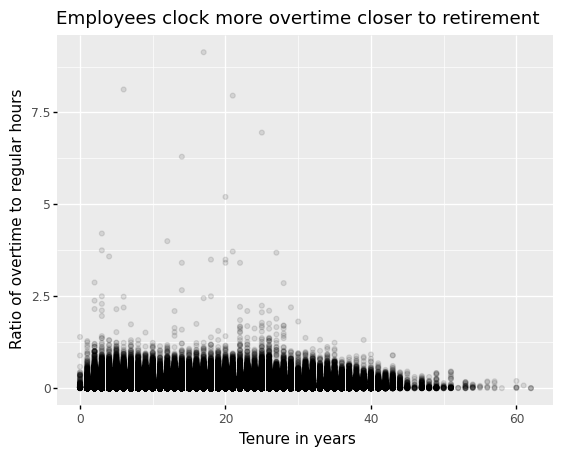

<ggplot: (333519539)>

In [11]:
from plotnine import *
(
        ggplot(df.query('ot_hours > 0').query('regular_hours > 0'), 
        aes(x='tenure_years', y='ot_hours/regular_hours')) 
    + geom_point(alpha=.1)
#     + facet_wrap('leave_status_as_of_june_30 == "CEASED"')
    + labs(title="Employees clock more overtime closer to retirement")
    + xlab('Tenure in years')
    + ylab('Ratio of overtime to regular hours')
)

In [62]:
import statsmodels.formula.api as smf

# YOU CAN ADD FILTERS HERE IF YOU WANT TO LOOK INTO A PARTICULAR AGENCY
# Let's start with no filters
to_model = df.query("agency_name=='DEPARTMENT OF CORRECTION'")

# title_description
# MODEL y=F(X) - which factors do you want to control for? 
# What do we think should explain the variance in overtime pay
model = smf.ols('ot_hours ~ regular_hours + tenure_years', data=to_model) 
# note that I added a squared term because it fits better
# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression

results = model.fit()
display(results.summary())

# FINDING OUTLIERS
# + E (what is still unaccounted for once you have controlled for those factors)
outliers = to_model.assign(
    predicted = results.predict(),
    residulas = results.resid,
    residuals_z = results.resid / results.resid.std()
    )\
    .sort_values(by='residuals_z', ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ot_hours   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     6963.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        11:35:51   Log-Likelihood:            -4.7632e+05
No. Observations:               67749   AIC:                         9.526e+05
Df Residuals:                   67746   BIC:                         9.527e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -105.2075      3.454    -30.463      0.000    -111.976     -98.438
regular_hours     0.1954      0.002    113.129      0.000       0.192       0.199
tenure_years      3.3003      0.131     25.174      0.000       3.043       3.557
==============================================================================
Omnibus:                    18751.561   Durbin-Watson:                   1.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58864.763
Skew:                           1.421   Prob(JB):                         0.00
Kurtosis:                       6.575   Cond. No.                     6.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
import statsmodels.formula.api as smf

# YOU CAN ADD FILTERS HERE IF YOU WANT TO LOOK INTO A PARTICULAR AGENCY
# Let's start with no filters
to_model = df.query("agency_name=='FIRE DEPARTMENT'")

# title_description
# MODEL y=F(X) - which factors do you want to control for? 
# What do we think should explain the variance in overtime pay
model = smf.ols('ot_hours ~ regular_hours + tenure_years', data=to_model) 
# note that I added a squared term because it fits better
# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression

results = model.fit()
display(results.summary())

# FINDING OUTLIERS
# + E (what is still unaccounted for once you have controlled for those factors)
outliers = to_model.assign(
    predicted = results.predict(),
    residulas = results.resid,
    residuals_z = results.resid / results.resid.std()
    )\
    .sort_values(by='residuals_z', ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ot_hours   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     9720.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        16:43:43   Log-Likelihood:            -6.1571e+05
No. Observations:               89030   AIC:                         1.231e+06
Df Residuals:                   89027   BIC:                         1.231e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -83.2825      3.306    -25.194      0.000     -89.762     -76.803
regular_hours     0.2150      0.002    138.873      0.000       0.212       0.218
tenure_years      1.2682      0.087     14.568      0.000       1.098       1.439
==============================================================================
Omnibus:                     9326.513   Durbin-Watson:                   1.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14262.508
Skew:                           0.782   Prob(JB):                         0.00
Kurtosis:                       4.184   Cond. No.                     7.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
df['total_pay'] = df.regular_gross_paid + df.total_ot_paid + df.total_other_pay

In [12]:
df.query('total_ot_paid == 248749.72')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years,total_pay
2291076,2021,996.00,NYC HOUSING AUTHORITY,PROCIDA,ROBERT,NaN,1987-04-13,BRONX,SUPERVISOR PLUMBER,ACTIVE,387.03,per Day,"1,820.00","100,627.80","2,249.50","248,749.72","7,215.34",2022-05-13 09:39:10.662085,35.00,"356,592.86"


In [13]:
df.groupby(by='agency_name').total_ot_paid.sum().reset_index().sort_values(by='total_ot_paid', ascending=False).head(5)

,agency_name,total_ot_paid
125,POLICE DEPARTMENT,"3,410,660,240.39"
88,FIRE DEPARTMENT,"1,596,842,055.03"
59,DEPARTMENT OF CORRECTION,"981,672,183.09"
65,DEPARTMENT OF SANITATION,"790,873,824.62"
114,NYC HOUSING AUTHORITY,"553,297,085.88"


In [14]:
# df.agency_name.value_counts().reset_index().head(20)

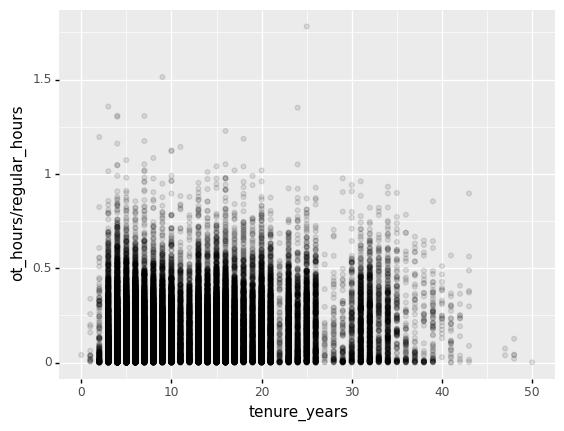

<ggplot: (829276860)>

In [63]:
from plotnine import *
(
    ggplot(df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.1)
)

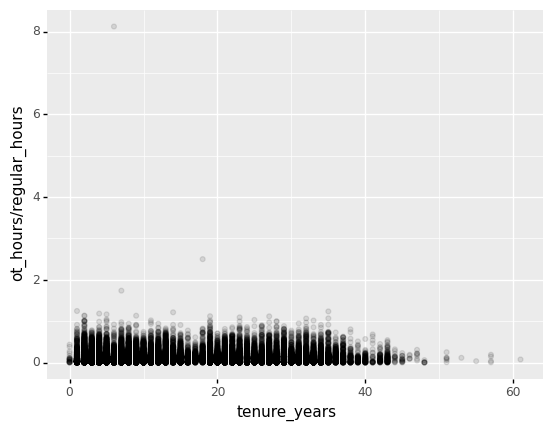

<ggplot: (808636621)>

In [65]:
(
    ggplot(df.query("agency_name=='NYC HOUSING AUTHORITY'").query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.1)
)

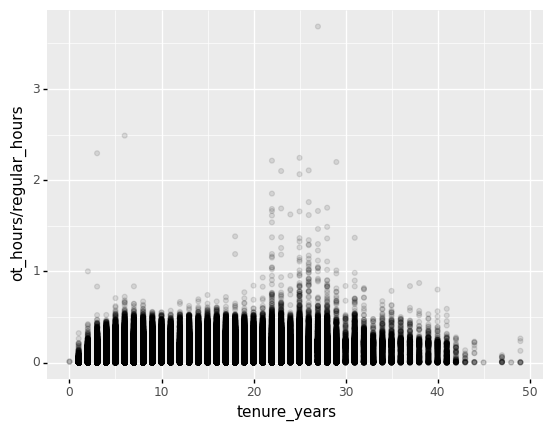

<ggplot: (826163642)>

In [66]:
(
    ggplot(df.query("agency_name=='POLICE DEPARTMENT'").query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.1)
)

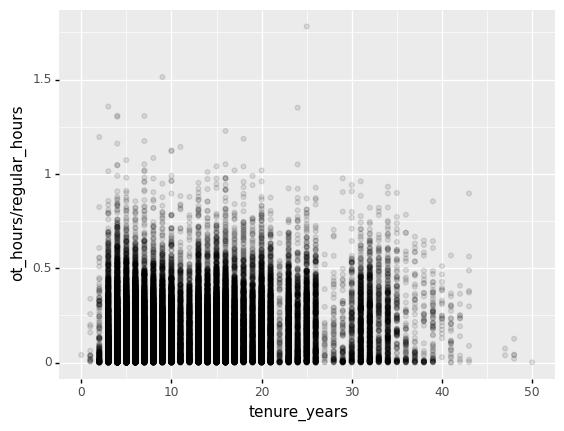

<ggplot: (402545349)>

In [22]:
(
    ggplot(to_model.query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours')) +
        geom_point(alpha=.1)
)    

In [68]:
agencies = ['DEPARTMENT OF CORRECTION', 'NYC HOUSING AUTHORITY', 'POLICE DEPARTMENT']

In [73]:
agencies_df = df[df.agency_name.isin(agencies)]
agencies_df.head(3)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years,total_pay
91106,2017,NaN,DEPARTMENT OF CORRECTION,AARON,SHELLON,NaN,2010-12-16,QUEENS,CORRECTION OFFICER,ACTIVE,"82,808.00",per Annum,"1,970.02","78,954.24",599.52,"43,311.50","14,064.12",2022-05-13 09:39:10.662085,11.00,"136,329.86"
91107,2017,NaN,DEPARTMENT OF CORRECTION,AAYAN,IBRAHIM,NaN,2016-06-27,QUEENS,CORRECTION OFFICER,ACTIVE,"43,042.00",per Annum,"2,085.72","42,209.08",411.75,"12,887.34","2,951.43",2022-05-13 09:39:10.662085,5.00,"58,047.85"
91108,2017,NaN,DEPARTMENT OF CORRECTION,ABASI,JUSTIN,NaN,2017-06-19,QUEENS,CORRECTION OFFICER,ACTIVE,"43,042.00",per Annum,74.28,825.46,0.00,0.00,0.00,2022-05-13 09:39:10.662085,4.00,825.46


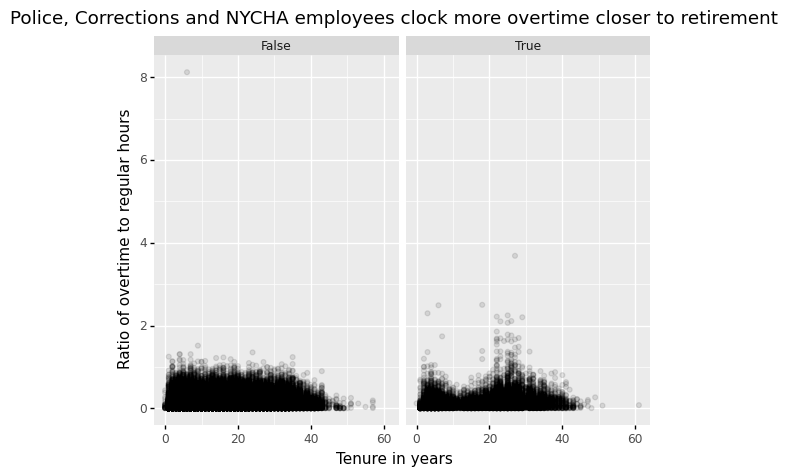

<ggplot: (746069092)>

In [83]:
(
    ggplot(agencies_df.query('ot_hours > 0').query('regular_hours > 0'), 
           aes(x='tenure_years', y='ot_hours/regular_hours'))
        + geom_point(alpha=.1)
        + facet_wrap('leave_status_as_of_june_30 == "CEASED"')
        + labs(title="Police, Corrections and NYCHA employees clock more overtime closer to retirement")
        + xlab('Tenure in years')
        + ylab('Ratio of overtime to regular hours')
)    

In [20]:
df.query('ot_hours/regular_hours > 5')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years,total_pay
74907,2017,NaN,COMMUNITY COLLEGE (MANHATTAN),GARAY,LUIS,NaN,2009-02-02,MANHATTAN,COLLEGE ASSISTANT,ACTIVE,12.00,per Hour,0.00,0.00,5.00,60.00,5.47,2022-05-08 21:48:13.717116,13.00,65.47
437032,2017,NaN,FIRE DEPARTMENT,BURKE,WILLIAM,O,1986-01-09,BROOKLYN,FIREFIGHTER,CEASED,"82,808.00",per Annum,0.00,"28,528.21",15.00,"5,510.90","2,609.71",2022-05-08 21:48:13.717116,36.00,"36,648.82"
452293,2017,NaN,FIRE DEPARTMENT,TUCKER,ROBERT,K,1994-10-23,BROOKLYN,FIREFIGHTER,CEASED,"82,808.00",per Annum,0.00,"22,229.02",9.00,"1,757.44","-1,129.45",2022-05-08 21:48:13.717116,27.00,"22,857.01"
529945,2017,NaN,POLICE DEPARTMENT,KUNDU,GOUTAM,NaN,2016-07-25,MANHATTAN,TRAFFIC ENFORCEMENT AGENT,CEASED,"30,706.00",per Annum,0.00,"-1,143.47",12.00,264.71,185.52,2022-05-08 21:48:13.717116,5.00,-693.24
558886,2017,NaN,POLICE DEPARTMENT,WALDRON,MICHAEL,G,2015-01-07,MANHATTAN,POLICE OFFICER,CEASED,"44,521.00",per Annum,0.00,"3,261.94",0.67,296.05,"1,468.83",2022-05-08 21:48:13.717116,7.00,"5,026.82"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861544,2021,740.00,DEPARTMENT OF EDUCATION ADMIN,TRAHAN,SHAMIKA,E,2019-06-16,QUEENS,CUSTOMER INFORMATION REPRESENTATIVE MA L 1549,CEASED,"40,345.00",per Annum,0.00,-771.60,0.50,11.04,760.56,2022-05-08 21:48:13.717116,2.00,-0.00
2861667,2021,841.00,DEPARTMENT OF TRANSPORTATION,MCCARTHY,DAVID,M,1988-08-29,QUEENS,AREA SUPERVISOR,CEASED,"114,869.00",per Annum,0.00,0.00,13.50,"1,123.57","-1,123.57",2022-05-08 21:48:13.717116,33.00,0.00
2861939,2021,56.00,POLICE DEPARTMENT,RIVERA JR,DAVID,NaN,2020-03-23,MANHATTAN,CITY CUSTODIAL ASSISTANT,CEASED,"32,260.00",per Annum,0.00,-23.13,2.50,20.86,0.00,2022-05-08 21:48:13.717116,2.00,-2.27
2862081,2021,56.00,POLICE DEPARTMENT,GIBSON,JEREMIAH,E,2020-03-24,MANHATTAN,CITY CUSTODIAL ASSISTANT,CEASED,"32,260.00",per Annum,0.00,0.00,2.50,20.86,-30.90,2022-05-08 21:48:13.717116,2.00,-10.04


In [21]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1')

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years,total_pay
93697,2017,NaN,DEPARTMENT OF CORRECTION,COBBINAH,FELIX,NaN,2017-05-30,BRONX,MARINE ENGINEER,ACTIVE,36.19,per Hour,135.50,"2,587.94",176.50,"5,450.32",0.00,2022-05-08 21:48:13.717116,4.00,"8,038.26"
614082,2018,72.00,DEPARTMENT OF CORRECTION,CHIN,RAWLE,C,2014-05-19,BRONX,MARINE OILER,ACTIVE,29.24,per Hour,"1,490.00","45,146.56","1,749.50","97,787.38",523.46,2022-05-08 21:48:13.717116,7.00,"143,457.40"
615946,2018,72.00,DEPARTMENT OF CORRECTION,COBBINAH,FELIX,NaN,2017-05-30,BRONX,MARINE ENGINEER,CEASED,36.19,per Hour,519.12,"21,105.89",543.25,"35,201.16",903.68,2022-05-08 21:48:13.717116,4.00,"57,210.73"
627404,2018,72.00,DEPARTMENT OF CORRECTION,DOUGHERTY,TIMOTHY,R,2018-03-19,QUEENS,MARINE ENGINEER,ACTIVE,36.20,per Hour,416.00,"15,059.20",435.00,"24,568.80",451.84,2022-05-08 21:48:13.717116,4.00,"40,079.84"
1162273,2019,72.00,DEPARTMENT OF CORRECTION,FITZMAURICE,DANIEL,NaN,2016-08-22,QUEENS,PLASTERER,ACTIVE,358.56,per Day,"1,824.97","93,223.89","1,958.50","189,371.03",0.00,2022-05-08 21:48:13.717116,5.00,"282,594.92"
1162767,2019,72.00,DEPARTMENT OF CORRECTION,CHIN,RAWLE,C,2014-05-19,BRONX,MARINE OILER,ACTIVE,34.52,per Hour,"1,646.78","69,349.66","1,678.25","87,317.51","4,129.62",2022-05-08 21:48:13.717116,7.00,"160,796.79"
1811427,2020,72.00,DEPARTMENT OF CORRECTION,MALCOLM,OMAR,T,2012-09-06,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","3,147.00","127,375.43","13,559.40",2022-05-08 21:48:13.717116,9.00,"251,320.46"
1811463,2020,72.00,DEPARTMENT OF CORRECTION,FOO,AINSWORTH,K,2004-08-12,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","2,118.50","96,209.69","18,323.60",2022-05-08 21:48:13.717116,17.00,"224,918.92"
1811574,2020,72.00,DEPARTMENT OF CORRECTION,DAVIS,QURAAN,NaN,2011-08-25,BROOKLYN,CORRECTION OFFICER,ACTIVE,"85,292.00",per Annum,"2,080.00","84,831.14","2,338.02","95,080.59","12,269.04",2022-05-08 21:48:13.717116,10.00,"192,180.77"
1811793,2020,72.00,DEPARTMENT OF CORRECTION,DOUGHERTY,TIMOTHY,R,2018-03-19,QUEENS,MARINE ENGINEER,ACTIVE,37.65,per Hour,"1,594.00","60,014.10","1,849.75","104,473.88","2,711.04",2022-05-08 21:48:13.717116,4.00,"167,199.02"


In [22]:
len(df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1'))

34

In [23]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').tenure_years.max()

25.0

In [24]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').tenure_years.min()

2.0

In [25]:
df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').sort_values(by='tenure_years', ascending=False)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years,total_pay
2638586,2021,72.00,DEPARTMENT OF CORRECTION,HOWARD,PATRICIA,NaN,1996-07-01,MANHATTAN,CORRECTION OFFICER,CEASED,"80,788.00",per Annum,32.00,"1,221.04",57.00,"1,923.92","16,202.09",2022-05-08 21:48:13.717116,25.00,"19,347.05"
2291089,2021,72.00,DEPARTMENT OF CORRECTION,GIVES,DEMETRIA,NaN,1997-10-23,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"128,355.00",per Annum,"2,080.00","127,452.46","2,809.50","162,012.85","24,946.87",2022-05-08 21:48:13.717116,24.00,"314,412.18"
2291383,2021,72.00,DEPARTMENT OF CORRECTION,BARNABY,MELVIN,NaN,1997-07-10,QUEENS,CAPTAIN,ACTIVE,"114,617.00",per Annum,"2,080.00","112,852.33","2,184.50","104,544.07","22,407.12",2022-05-08 21:48:13.717116,24.00,"239,803.52"
2295144,2021,72.00,DEPARTMENT OF CORRECTION,JAMES,TERRANCE,NaN,2001-06-07,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","92,454.16","2,118.00","81,470.45","21,591.93",2022-05-08 21:48:13.717116,20.00,"195,516.54"
2291222,2021,72.00,DEPARTMENT OF CORRECTION,MASSEY-COVINGTO,DARLENE,E,2004-03-04,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"128,355.00",per Annum,"2,080.00","127,452.46","2,161.00","111,907.50","19,537.03",2022-05-08 21:48:13.717116,18.00,"258,896.99"
2293891,2021,72.00,DEPARTMENT OF CORRECTION,IP,KENNY,C,2004-02-12,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","92,454.16","2,467.03","94,632.39","16,524.24",2022-05-08 21:48:13.717116,18.00,"203,610.79"
1811463,2020,72.00,DEPARTMENT OF CORRECTION,FOO,AINSWORTH,K,2004-08-12,QUEENS,WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,ACTIVE,"111,142.00",per Annum,"2,080.00","110,385.63","2,118.50","96,209.69","18,323.60",2022-05-08 21:48:13.717116,17.00,"224,918.92"
2297787,2021,72.00,DEPARTMENT OF CORRECTION,MATURA,ILYA,V,2005-12-27,BRONX,MARINE ENGINEER,ACTIVE,"64,231.00",per Annum,"1,664.00","64,050.10","2,042.50","115,360.40","3,614.72",2022-05-08 21:48:13.717116,16.00,"183,025.22"
2291281,2021,72.00,DEPARTMENT OF CORRECTION,BLACKWOOD,CARLOS,NaN,2005-06-09,QUEENS,CAPTAIN,ACTIVE,"114,617.00",per Annum,"2,080.00","113,582.67","2,186.25","123,996.94","12,267.56",2022-05-08 21:48:13.717116,16.00,"249,847.17"
2295466,2021,72.00,DEPARTMENT OF CORRECTION,DUPAL,LORRAINE,NaN,2006-11-09,QUEENS,CORRECTION OFFICER,ACTIVE,"92,073.00",per Annum,"2,080.00","92,454.16","2,162.57","92,188.62","9,557.41",2022-05-08 21:48:13.717116,15.00,"194,200.19"


In [67]:
# df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').query('ot_hours > 1000').sort_values(by='ot_hours', ascending=False)

In [27]:
len(df.query("agency_name=='DEPARTMENT OF CORRECTION'").query('ot_hours/regular_hours > 1').query('ot_hours > 1500').sort_values(by='ot_hours', ascending=False))

23

In [28]:
df.sort_values(by='total_other_pay', ascending=False)

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years,total_pay
1705625,2020,56.00,POLICE DEPARTMENT,MORALES,JOSE,NaN,1998-12-20,MANHATTAN,SUPERVISOR OF SCHOOL SECURITY,CEASED,"57,813.00",per Annum,0.00,0.00,0.00,0.00,"650,000.00",2022-05-08 21:48:13.717116,23.00,"650,000.00"
2291075,2021,56.00,POLICE DEPARTMENT,NaN,NaN,NaN,1984-07-16,MANHATTAN,CAPTAIN DETAILED AS CHIEF OF TRAINING,CEASED,"241,116.00",per Annum,400.00,"46,222.47",0.00,0.00,"312,126.91",2022-05-08 21:48:13.717116,37.00,"358,349.38"
1765949,2020,57.00,FIRE DEPARTMENT,MCKAVANAGH,THOMAS,E,1979-11-24,BROOKLYN,ASSISTANT CHIEF OF DEPARTMENT,CEASED,"234,096.00",per Annum,0.00,0.00,0.00,0.00,"288,271.24",2022-05-08 21:48:13.717116,42.00,"288,271.24"
1765947,2020,57.00,FIRE DEPARTMENT,HODGENS,JAMES,C,1981-11-07,BROOKLYN,ASSISTANT CHIEF OF DEPARTMENT,CEASED,"234,096.00",per Annum,542.88,"60,777.03",0.00,0.00,"287,075.37",2022-05-08 21:48:13.717116,40.00,"347,852.40"
1765948,2020,57.00,FIRE DEPARTMENT,BAGGOTT,EDWARD,J,1982-01-09,BROOKLYN,ASSISTANT CHIEF OF DEPARTMENT,CEASED,"234,096.00",per Annum,571.43,"63,974.73",0.00,0.00,"276,507.97",2022-05-08 21:48:13.717116,40.00,"340,482.70"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860737,2021,57.00,FIRE DEPARTMENT,PENA,LICEETT,Y,1996-03-17,MANHATTAN,EMERGENCY MEDICAL SPECIALIST-PARAMEDIC,CEASED,"57,402.00",per Annum,0.00,"159,487.47",0.00,0.00,"-159,487.47",2022-05-08 21:48:13.717116,26.00,0.00
1136316,2019,57.00,FIRE DEPARTMENT,MCKIE,JOSEPH,A,1988-12-05,BROOKLYN,BATTALION CHIEF,CEASED,"163,454.00",per Annum,"1,611.45","129,421.05",0.00,0.00,"-165,634.25",2022-05-08 21:48:13.717116,33.00,"-36,213.20"
1136320,2019,57.00,FIRE DEPARTMENT,JAKUBOWSKI,DAVID,W,1978-09-02,BROOKLYN,DEPUTY CHIEF,CEASED,"181,172.00",per Annum,"1,234.32","110,690.66",0.00,0.00,"-187,536.86",2022-05-08 21:48:13.717116,43.00,"-76,846.20"
451275,2017,NaN,FIRE DEPARTMENT,SPADAFORA,RONALD,R,1978-09-02,BROOKLYN,ASSISTANT CHIEF OF DEPARTMENT,ACTIVE,"219,707.00",per Annum,"2,085.72","226,081.84",0.00,0.00,"-205,816.45",2022-05-08 21:48:13.717116,43.00,"20,265.39"


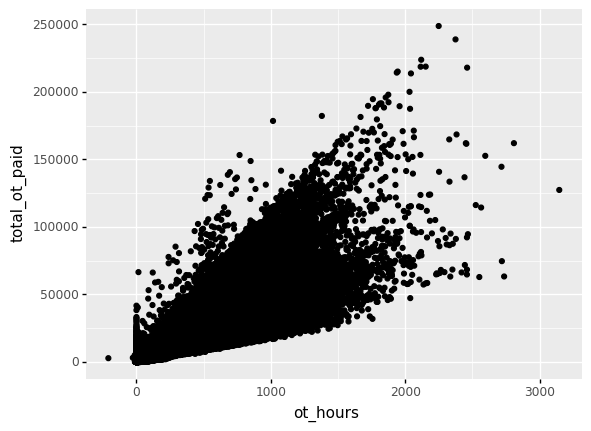

<ggplot: (845538728)>

In [24]:
(
    ggplot(df.query('total_ot_paid > 0'),          # data
        aes('ot_hours', 'total_ot_paid')) # aesthetics
        + geom_point()      # geometry
)

In [27]:
df.query('ot_hours > regular_hours and ot_hours > 0').agency_name.value_counts().head(10)

POLICE DEPARTMENT                 86
FIRE DEPARTMENT                   68
ADMIN FOR CHILDREN'S SVCS         64
DEPT OF PARKS & RECREATION        45
NYC HOUSING AUTHORITY             40
DEPARTMENT OF CORRECTION          34
DEPT OF ENVIRONMENT PROTECTION    32
LAW DEPARTMENT                    22
DEPT OF HEALTH/MENTAL HYGIENE     16
DEPARTMENT OF EDUCATION ADMIN     15
Name: agency_name, dtype: int64

In [38]:
df.query('ot_hours > regular_hours and ot_hours > 0').groupby(by='agency_name').total_ot_paid.sum().sort_values(ascending=False).head(10)

agency_name
NYC HOUSING AUTHORITY           3,383,894.15
DEPARTMENT OF CORRECTION        2,584,581.46
ADMIN FOR CHILDREN'S SVCS       1,777,614.18
DEPT OF HEALTH/MENTAL HYGIENE   1,584,116.51
FIRE DEPARTMENT                 1,362,082.15
BOARD OF ELECTION               1,355,792.26
POLICE DEPARTMENT                 875,610.42
DEPT OF CITYWIDE ADMIN SVCS       471,110.32
DEPT. OF HOMELESS SERVICES        279,557.81
HRA/DEPT OF SOCIAL SERVICES       175,735.37
Name: total_ot_paid, dtype: float64

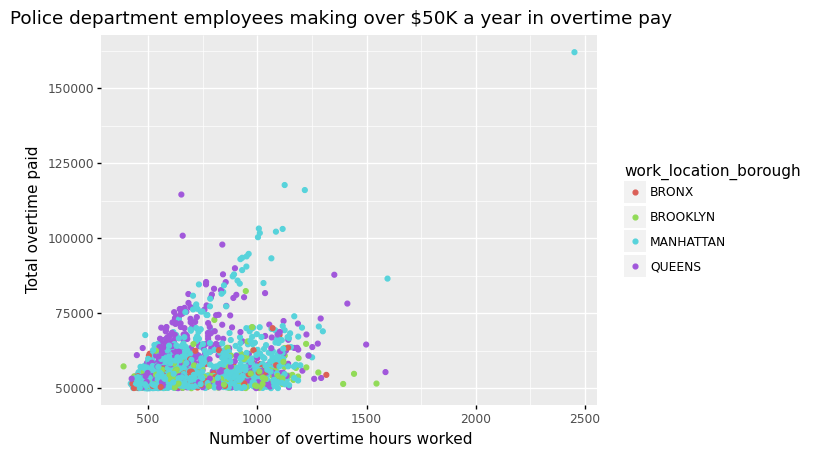

<ggplot: (844583246)>

In [57]:
(
    ggplot(df.query('agency_name == "POLICE DEPARTMENT" and ot_hours > 0 and total_ot_paid > 50000'),
        aes('ot_hours', 'total_ot_paid'))
#         + facet_wrap('title_description')
        + geom_point(aes(color='work_location_borough'))
        + labs(title="Police department employees making over $50K a year in overtime pay")
        + xlab('Number of overtime hours worked')
        + ylab('Total overtime paid')
)

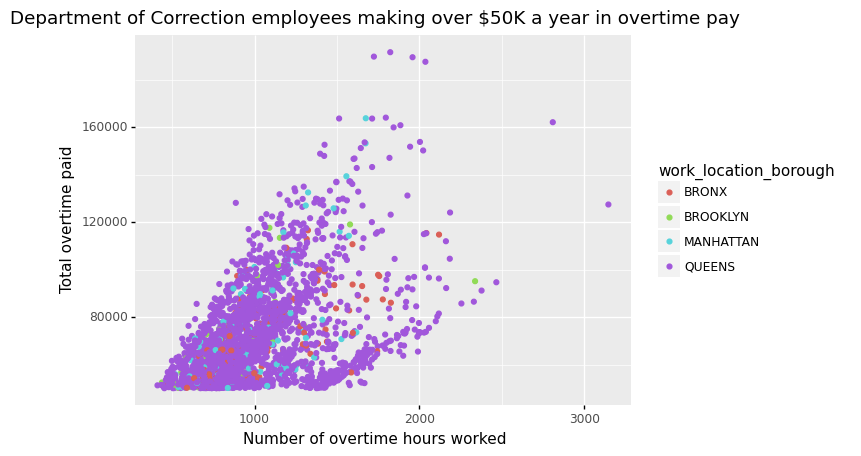

<ggplot: (746894814)>

In [55]:
(
    ggplot(df.query('agency_name == "DEPARTMENT OF CORRECTION" and ot_hours > 0 and total_ot_paid > 50000'),
        aes('ot_hours', 'total_ot_paid'))
#         + facet_wrap('title_description')
        + geom_point(aes(color='work_location_borough'))
        + labs(title="Department of Correction employees making over $50K a year in overtime pay")
        + xlab('Number of overtime hours worked')
        + ylab('Total overtime paid')
    
)

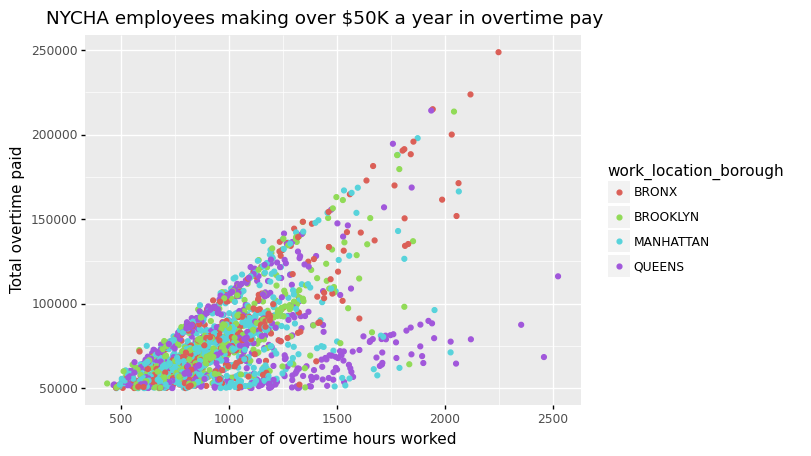

<ggplot: (836821560)>

In [58]:
(
    ggplot(df.query('agency_name == "NYC HOUSING AUTHORITY" and ot_hours > 0 and total_ot_paid > 50000'),
        aes('ot_hours', 'total_ot_paid'))
        + geom_point(aes(color='work_location_borough'))
        + labs(title="NYCHA employees making over $50K a year in overtime pay")
        + xlab('Number of overtime hours worked')
        + ylab('Total overtime paid')
)

<AxesSubplot:ylabel='fiscal_year'>

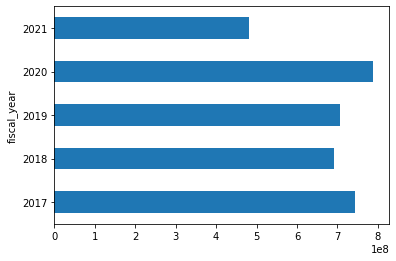

In [86]:
df.query('agency_name == "POLICE DEPARTMENT"').groupby(by='fiscal_year').total_ot_paid.sum().plot(kind='barh')

In [97]:
df.query("first_name.isna() and fiscal_year==2020")

,fiscal_year,payroll_number,agency_name,last_name,first_name,mid_init,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,today,tenure_years,total_pay
1832002,2020,300.00,BOARD OF ELECTION POLL WORKERS,FEUCHT,NaN,W,2019-01-01,MANHATTAN,ELECTION WORKER,ACTIVE,1.00,per Hour,0.00,"3,995.00",0.00,0.00,0.00,2022-05-13 09:39:10.662085,3.00,"3,995.00"
1969102,2020,300.00,BOARD OF ELECTION POLL WORKERS,ZHANG,NaN,N,2016-01-01,MANHATTAN,ELECTION WORKER,ACTIVE,1.00,per Hour,0.00,250.00,0.00,0.00,0.00,2022-05-13 09:39:10.662085,6.00,250.00
1972440,2020,463.00,COMMUNITY COLLEGE (BRONX),LUO,NaN,NaN,2017-01-23,QUEENS,ADJUNCT ASSISTANT PROFESSOR,SEASONAL,45.68,per Day,80.00,"3,654.00",0.00,0.00,211.33,2022-05-13 09:39:10.662085,5.00,"3,865.33"
1991673,2020,469.00,COMMUNITY COLLEGE (LAGUARDIA),XU,NaN,NaN,2014-09-01,QUEENS,ASSOCIATE PROFESSOR,ACTIVE,"91,030.00",per Annum,260.00,"89,719.41",0.00,0.00,0.00,2022-05-13 09:39:10.662085,7.00,"89,719.41"
1993797,2020,469.00,COMMUNITY COLLEGE (LAGUARDIA),XU,NaN,NaN,2018-06-18,QUEENS,ASSOCIATE PROFESSOR,CEASED,87.54,per Hour,90.00,"7,878.60",0.00,0.00,0.00,2022-05-13 09:39:10.662085,3.00,"7,878.60"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234151,2020,906.00,DISTRICT ATTORNEY-SPECIAL NARC,NaN,NaN,NaN,1996-11-18,MANHATTAN,SENIOR RACKETS INVESTIGATOR,CEASED,"82,032.00",per Annum,0.00,0.00,0.00,0.00,"9,361.32",2022-05-13 09:39:10.662085,25.00,"9,361.32"
2234152,2020,906.00,DISTRICT ATTORNEY-SPECIAL NARC,NaN,NaN,NaN,1993-08-02,MANHATTAN,SENIOR RACKETS INVESTIGATOR,CEASED,"85,676.00",per Annum,0.00,0.00,0.00,0.00,"9,342.60",2022-05-13 09:39:10.662085,28.00,"9,342.60"
2234153,2020,906.00,DISTRICT ATTORNEY-SPECIAL NARC,NaN,NaN,NaN,1989-07-05,MANHATTAN,SENIOR RACKETS INVESTIGATOR,CEASED,"78,342.00",per Annum,0.00,0.00,0.00,0.00,"9,164.49",2022-05-13 09:39:10.662085,32.00,"9,164.49"
2234161,2020,906.00,DISTRICT ATTORNEY-SPECIAL NARC,NaN,NaN,NaN,2012-05-07,MANHATTAN,SENIOR RACKETS INVESTIGATOR,CEASED,"63,054.00",per Annum,0.00,0.00,0.00,0.00,"4,442.82",2022-05-13 09:39:10.662085,10.00,"4,442.82"
